# Performing the bilinear system identification using the split-op propagator

The propagation follows [absorbing_boundary.ipynb](https://github.com/dibondar/QuantumClassicalDynamics/blob/master/absorbing_boundary.ipynb)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('') + '/QuantumClassicalDynamics')

from QuantumClassicalDynamics.imag_time_propagation import ImgTimePropagation, np, fftpack

from numba import njit # compile python
from scipy.signal import blackman
from scipy.linalg import eig
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # enable log color plot

In [2]:
from bi_sys_id_my_version import estimate_rank, bi_sys_id_my_version, get_response, get_training_responses

In [3]:
# Define parameters of an atom (a single-electron model of Ar) in the external laser field

# laser field frequency
omega_laser = 0.06

# the final time of propagation (= 8 periods of laser oscillations)
t_final = 8 * 2. * np.pi / omega_laser

# amplitude of the laser field strength
F = 0.04

# the amplitude of grid
x_amplitude = 100.

# the time step
dt = 0.05

@njit
def laser(t):
    """
    The strength of the laser field.
    Always add an envelop to the laser field to avoid all sorts of artifacts.
    We use a sin**2 envelope, which resembles the Blackman filter
    """
    return F * np.sin(omega_laser * t) * np.sin(np.pi * t / t_final) ** 2

@njit
def v(x, t=0.):
    """
    Potential energy.
    
    Define the  potential energy as a sum of the soft core Columb potential
    and the laser field interaction in the dipole approximation.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) + x * laser(t)

@njit
def diff_v(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5) + laser(t)

@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
                                                
@njit
def diff_k(p, t=0.):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p

@njit
def abs_boundary(x):
    """
    Absorbing boundary similar to the Blackman filter
    """
    return np.sin(0.5 * np.pi * (x + x_amplitude) / x_amplitude) ** (0.05 * dt)

sys_params = dict(
    dt=dt,
    x_grid_dim=1024,
    x_amplitude=x_amplitude,
    
    k=k,
    diff_k=diff_k,
    v=v,
    diff_v=diff_v,
    
    abs_boundary=abs_boundary,
)

In [ ]:

#########################################################################
#
#   Define functions for testing and visualizing
#
#########################################################################


def test_propagation(sys, iterations=None):
    """
    Run tests for the specified propagators and plot the probability density
    of the time dependent propagation
    :param sys: class that propagates
    """
    # Set the ground state wavefunction as the initial condition
    sys.get_stationary_states(1)
    sys.set_wavefunction(sys.stationary_states[0])

    iterations = iterations if iterations else 748
    # steps = int(round(t_final / sys.dt / iterations))
    steps = 1
    
    # display the propagator
    extent=[sys.x.min(), sys.x.max(), 0., sys.t]
    
    plt.imshow(
        [np.abs(sys.propagate(steps)) ** 2 for _ in range(iterations)],
        origin='lower',
        norm=LogNorm(vmin=1e-12, vmax=0.1),
        #extent=extent,
        aspect=50,#aspect=((extent[-1] - extent[-2]) / (extent[1] - extent[0]))
        
    )
    plt.xlabel('coordinate $x$ (a.u.)')
    plt.ylabel('time $t$ (a.u.)')
    #plt.colorbar()


def test_Ehrenfest1(sys):
    """
    Test the first Ehenfest theorem for the specified quantum system
    """
    times = sys.dt * np.arange(len(sys.x_average))

    dx_dt = np.gradient(sys.x_average, sys.dt)

    print("{:.2e}".format(np.linalg.norm(dx_dt - sys.x_average_rhs)))

    plt.plot(times, dx_dt, '-r', label='$d\\langle\\hat{x}\\rangle / dt$')
    plt.plot(times, sys.x_average_rhs, '--b', label='$\\langle\\hat{p}\\rangle$')
    plt.legend()
    plt.ylabel('momentum')
    plt.xlabel('time $t$ (a.u.)')


def test_Ehrenfest2(sys):
    """
    Test the second Ehenfest theorem for the specified quantum system
    """
    times = sys.dt * np.arange(len(sys.p_average))

    dp_dt = np.gradient(sys.p_average, sys.dt)

    print("{:.2e}".format(np.linalg.norm(dp_dt - sys.p_average_rhs)))

    plt.plot(times, dp_dt, '-r', label='$d\\langle\\hat{p}\\rangle / dt$')
    plt.plot(times, sys.p_average_rhs, '--b', label='$\\langle -U\'(\\hat{x})\\rangle$')
    plt.legend()
    plt.ylabel('force')
    plt.xlabel('time $t$ (a.u.)')

In [ ]:

#########################################################################
#
#   Declare the propagators
#
#########################################################################

# sys_no_abs_boundary = ImgTimePropagation(**sys_params)



sys_with_abs_boundary = ImgTimePropagation(
    **sys_params
)


In [ ]:

#########################################################################
#
# Test propagation in the context of High Harmonic Generation
#
#########################################################################

#plt.subplot(121)
#plt.title("No absorbing boundary, $|\\Psi(x, t)|^2$")
#test_propagation(sys_no_abs_boundary)

#plt.subplot(122)
plt.title("Absorbing boundary, $|\\Psi(x, t)|^2$")
test_propagation(sys_with_abs_boundary)

plt.show()

In [ ]:
#plt.subplot(221)
#plt.title("No absorbing boundary")
#print("\nNo absorbing boundary error in the first Ehrenfest relation: ")
#test_Ehrenfest1(sys_no_abs_boundary)

#plt.subplot(222)
#plt.title("No absorbing boundary")
#print("\nNo absorbing boundary error in the second Ehrenfest relation: ")
#test_Ehrenfest2(sys_no_abs_boundary)

#plt.subplot(223)
plt.title("Absorbing boundary")
print("\nWith absorbing boundary error in the first Ehrenfest relation: ")
test_Ehrenfest1(sys_with_abs_boundary)

plt.show()

#plt.subplot(224)
plt.title("Absorbing boundary")
print("\nWith absorbing boundary error in the second Ehrenfest relation: ")
test_Ehrenfest2(sys_with_abs_boundary)

plt.show()

In [ ]:

def plot_spectrum(sys):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    N = len(sys.p_average_rhs)
    k = np.arange(N)

    # frequency range
    omegas = (k - N / 2) * np.pi / (0.5 * sys.t)

    # spectra of the
    spectrum = np.abs(
        # used windows fourier transform to calculate the spectra
        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
        fftpack.fft((-1) ** k * blackman(N) * sys.p_average_rhs)
    ) ** 2
    spectrum /= spectrum.max()

    plt.semilogy(omegas / omega_laser, spectrum)
    plt.ylabel('spectrum (arbitrary units)')
    plt.xlabel('frequency / $\\omega_L$')
    plt.xlim([0, 30.])
    plt.ylim([1e-11, 1.])

#plt.subplot(121)
#plt.title("No absorbing boundary High Harmonic Generation Spectrum")
#plot_spectrum(sys_no_abs_boundary)

#plt.subplot(122)
plt.title("With absorbing boundary High Harmonic Generation Spectrum")
plot_spectrum(sys_with_abs_boundary)

plt.show()

# Generate responces for system identification

In [172]:
# system parameters without the potential energy laser field
common_sys_params = dict(
        dt=dt,
        x_grid_dim=1024,
        x_amplitude=x_amplitude,

        k=k,
        diff_k=diff_k,
        
        #abs_boundary=abs_boundary,
)

# amplitude of the laser field strength
F = 0.1

@njit
def v_pulse_off(x, t=0.):
    """
    Potential energy with field off.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) 

@njit
def diff_v_pulse_off(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5)

@njit
def v_pulse_on(x, t=0.):
    """
    Potential energy with field on.
    """
    return v_pulse_off(x) + x * F

@njit
def diff_v_pulse_on(x, t=0.):
    """
    the derivative of the potential energy
    """
    return diff_v_pulse_off(x) + F

# get the ground state
sys = ImgTimePropagation(
    v = v_pulse_off,
    **common_sys_params
)
sys.get_stationary_states(1)
ground_state = sys.stationary_states[0]


control_off_tsteps = 1000

orig_responces = []

for control_on_tsteps in range(1, 30):
    
    # propagate with field on
    sys = ImgTimePropagation(
        v = v_pulse_on,
        diff_v = diff_v_pulse_on,
        **common_sys_params
    ).set_wavefunction(ground_state)
    
    # save the initial point
    sys.get_ehrenfest()
    
    displaced_state = sys.propagate(control_on_tsteps)

    response_field_on = sys.p_average
    
    # propagate with field off
    sys = ImgTimePropagation(
        v = v_pulse_off,
        diff_v = diff_v_pulse_off,
        **common_sys_params
    ).set_wavefunction(displaced_state)

    sys.propagate(control_off_tsteps - control_on_tsteps - 1)
    
    # save the output with the fild on and off
    orig_responces.append(
        response_field_on + sys.p_average
    )

In [173]:
orig_responces = np.array(orig_responces)

In [174]:
# times of propagation
times = dt * np.arange(orig_responces.shape[1])

In [175]:
rank, sigma = estimate_rank(np.array(orig_responces), alpha=int(orig_responces.shape[1] / 2))

Estimated rank  5
[1.14932941e+00 1.04037270e+00 4.43707916e-02 3.77307833e-02
 4.72505861e-03 1.83495376e-03 2.65580268e-04 1.22697010e-04
 1.28263729e-05 4.83699524e-06 4.58929222e-07 1.91236904e-08
 1.82694189e-08 1.35933733e-08 9.03372496e-09 8.45098329e-09
 5.37319842e-09 5.00396159e-09 5.00255149e-09 3.39526550e-09
 3.29005132e-09 3.19479579e-09 2.30815222e-09 2.29566318e-09
 1.66090693e-09 1.63149969e-09 1.22847017e-09 1.18394036e-09
 9.21384978e-10 8.76902908e-10 6.98226397e-10 6.60395666e-10
 5.33863028e-10 5.04436492e-10 4.11583377e-10 3.90177562e-10
 3.19784511e-10 3.05315270e-10 2.50275301e-10 2.41553126e-10
 1.97220859e-10 1.93099347e-10 1.67348875e-10 1.56343025e-10
 1.55757901e-10 1.26447316e-10 1.24757883e-10 1.03015135e-10
 1.00112530e-10 8.40740688e-11 8.07829282e-11 6.87181236e-11
 6.55430793e-11 5.62824134e-11 5.34707175e-11 4.62233950e-11
 4.38696147e-11 3.80880410e-11 3.62140944e-11 3.15059068e-11
 3.01200168e-11 2.61704979e-11 2.53649191e-11 2.21626642e-11
 2.183

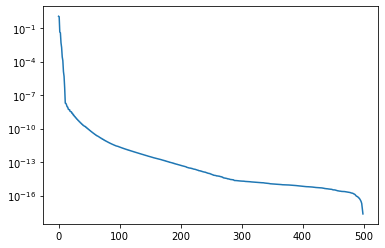

In [176]:
plt.semilogy(sigma)
#plt.xlim([0, 200])

In [177]:
reconstructed = bi_sys_id_my_version(
    orig_responces,
    alpha = int(orig_responces.shape[1] / 2),
    dt = dt,
    v = [F],
)

logm result may be inaccurate, approximate err = 5.836497301933703e-11


In [178]:
reconstructed_responses = get_training_responses(reconstructed, times=times, p=orig_responces.shape[0], u=F)

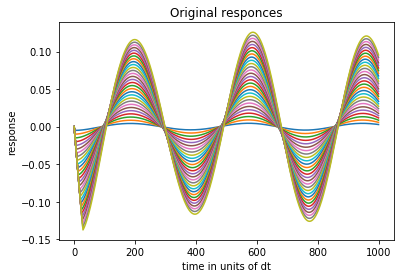

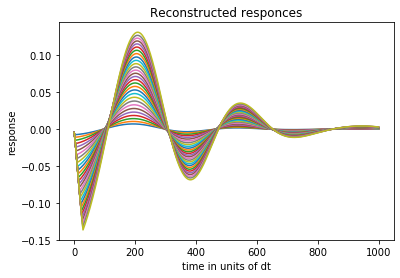

In [179]:
plt.title("Original responces")
plt.plot(orig_responces.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

plt.title("Reconstructed responces")
plt.plot(reconstructed_responses.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

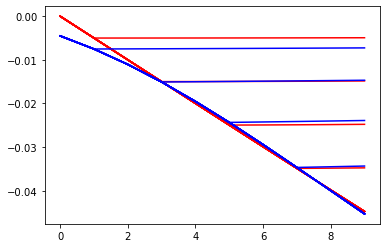

In [182]:
plt.plot(orig_responces[::2].T[:10], 'r')
plt.plot(reconstructed_responses[::2].T[:10], 'b')
plt.show()

In [181]:
eig(reconstructed.Ac)

(array([-0.09103606+0.48715773j, -0.09103606-0.48715773j,
        -0.08530237+0.33707487j, -0.08530237-0.33707487j,
        -0.12473586+0.j        ]),
 array([[-0.21338139+0.10945154j, -0.21338139-0.10945154j,
          0.08791175+0.60131486j,  0.08791175-0.60131486j,
         -0.34601348+0.j        ],
        [ 0.14935755+0.34741862j,  0.14935755-0.34741862j,
          0.66853818+0.j        ,  0.66853818-0.j        ,
         -0.11386722+0.j        ],
        [-0.64640854+0.j        , -0.64640854-0.j        ,
         -0.23387982+0.09952882j, -0.23387982-0.09952882j,
          0.16561749+0.j        ],
        [ 0.10245817+0.60720516j,  0.10245817-0.60720516j,
          0.15994086+0.25865839j,  0.15994086-0.25865839j,
         -0.4501348 +0.j        ],
        [-0.0380407 +0.03153559j, -0.0380407 -0.03153559j,
         -0.15283957-0.05742594j, -0.15283957+0.05742594j,
          0.79828468+0.j        ]]))

In [186]:
reconstructed.C @ reconstructed.x0

array([[-0.00451181]])